# Kannada MNIST
MNIST-szerű adathalmaz kannada kézzel írt számjegyekre

# Adatkészlet Leírás
A train.csv és a test.csv adatfájlok kézzel rajzolt számjegyek szürkeárnyalatos képeit tartalmazzák, nullától kilencig, kannadai írásmódban.

Minden kép 28 pixel magas és 28 pixel széles, összesen 784 pixeles. Minden egyes pixelhez egyetlen pixelérték tartozik, amely az adott pixel világosságát vagy sötétségét jelzi, a magasabb számok sötétebbet jelentenek. Ez a pixelérték egy egész szám 0 és 255 között.

A train.csv nevű képzési adathalmaz 785 oszlopot tartalmaz. Az első oszlop, az úgynevezett label, a felhasználó által rajzolt számjegy. A többi oszlop a hozzátartozó kép pixelértékeit tartalmazza.

A tréninghalmaz minden egyes pixeloszlopának neve pixel{x}, ahol x egy egész szám 0 és 783 között. Ahhoz, hogy megtaláljuk ezt a képpontot a képen, tegyük fel, hogy x-et a következőképpen bontottuk fel: x = i * 28 + j, ahol i és j 0 és 27 közötti egész számok. Ekkor a pixel{x} egy 28 x 28-as mátrix i. sorában és j. oszlopában található (indexelés nullával).

Például a 31. pixel azt a pixelt jelöli, amely a balról a negyedik oszlopban és a felülről a második sorban van, ahogy az alábbi ascii-diagramon is látható.

Vizuálisan, ha elhagyjuk a "pixel" előtagot, a pixelek így alkotják a képet:
```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```
A tesztadathalmaz, a test.csv, megegyezik a képzési halmazzal, kivéve, hogy nem tartalmazza a címke oszlopot.

A verseny értékelési mérőszáma a kategorizálási pontosság, vagyis a helyesen osztályozott tesztképek aránya. Például a 0,97-es kategorizálási pontosság azt jelenti, hogy a képek 3%-a kivételével az összes képet helyesen osztályozta.

Fájlok
train.csv - a gyakorlóhalmaz
test.csv - a tesztkészlet
sample_submission.csv - a megfelelő formátumú minta beküldési fájl.
Dig-MNIST.csv - egy további címkézett karakterkészlet, amely a modell eredményeinek validálására vagy tesztelésére használható a ranglistára való beküldés előtt.

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_theme(style="whitegrid")
from imageio import imwrite
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from PIL import Image, ImageChops

# Mik azok a SOM-ok?
Röviden, az önszerveződő térképek a mesterséges neurális hálózatok egy olyan típusa, amely a kompetitív tanuláson alapul (eltérően a más NN-ekre jellemző hibajavító tanulástól). Az ötlet lényege, hogy a vektorok (vagy csomópontok) összekapcsolt kétdimenziós mátrixát iteratív módon a bemeneti adathalmaz magasabb dimenziós topológiájához igazítják. Minden ciklusban kiválasztunk egy csomópontot, és annak elemeit (a súlyokat) a szomszédaiéval együtt frissítjük, hogy megközelítsenek egy véletlenszerűen kiválasztott adatpontot a képzési halmazból. A versengő elem a frissítési szakasz során lép működésbe, mivel minden egyes iterációban a kivont adatponthoz (egy kiválasztott metrika szerint) legközelebbi csomópontot választjuk ki a súlyok frissítéséhez.

A SOM-ok különösen alkalmasak olyan esetekre, amikor az alacsony dimenziójú sokaságok magasabb dimenziókban rejtőznek, és gyakran használják együtt és/vagy versengve más dimenziócsökkentő módszerekkel, különösen a Principal Component Analysis (PCA) módszerével, amelynek nemlineáris általánosításának tekinthető: a SOM előnyeinek és hátrányainak kimerítő magyarázata azonban meghaladja e füzet kereteit, de rengeteg forrás található az interneten azok számára, akik többet szeretnének tudni.

In [4]:
%pip install SimpSOM

Note: you may need to restart the kernel to use updated packages.


In [5]:
import simpsom as sps

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
DirPath='./Kannada-MNIST - DataSet/train.csv'

Az adatok előkészítése

In [10]:
np.random.seed(0)

# get part of the dataset
train = pd.read_csv(DirPath)
# display(train.head())s
train = train.sample(n=600, random_state=0)
labels = train['label']
train = train.drop("label",axis=1)

<Axes: xlabel='label', ylabel='count'>

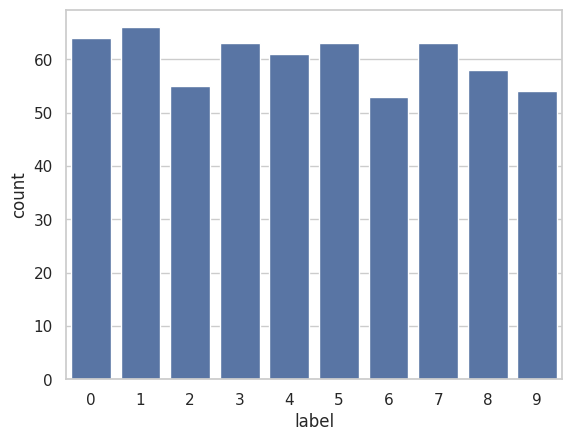

In [11]:
# check distribution
sns.countplot(x=labels)

In [12]:
# standardization of a dataset
train_st = StandardScaler().fit_transform(train.values)

A SOM képzése

Periodic Boundary Conditions active.
The weights will be initialized with PCA.
The map will be trained with the batch algorithm.
Training SOM... done!


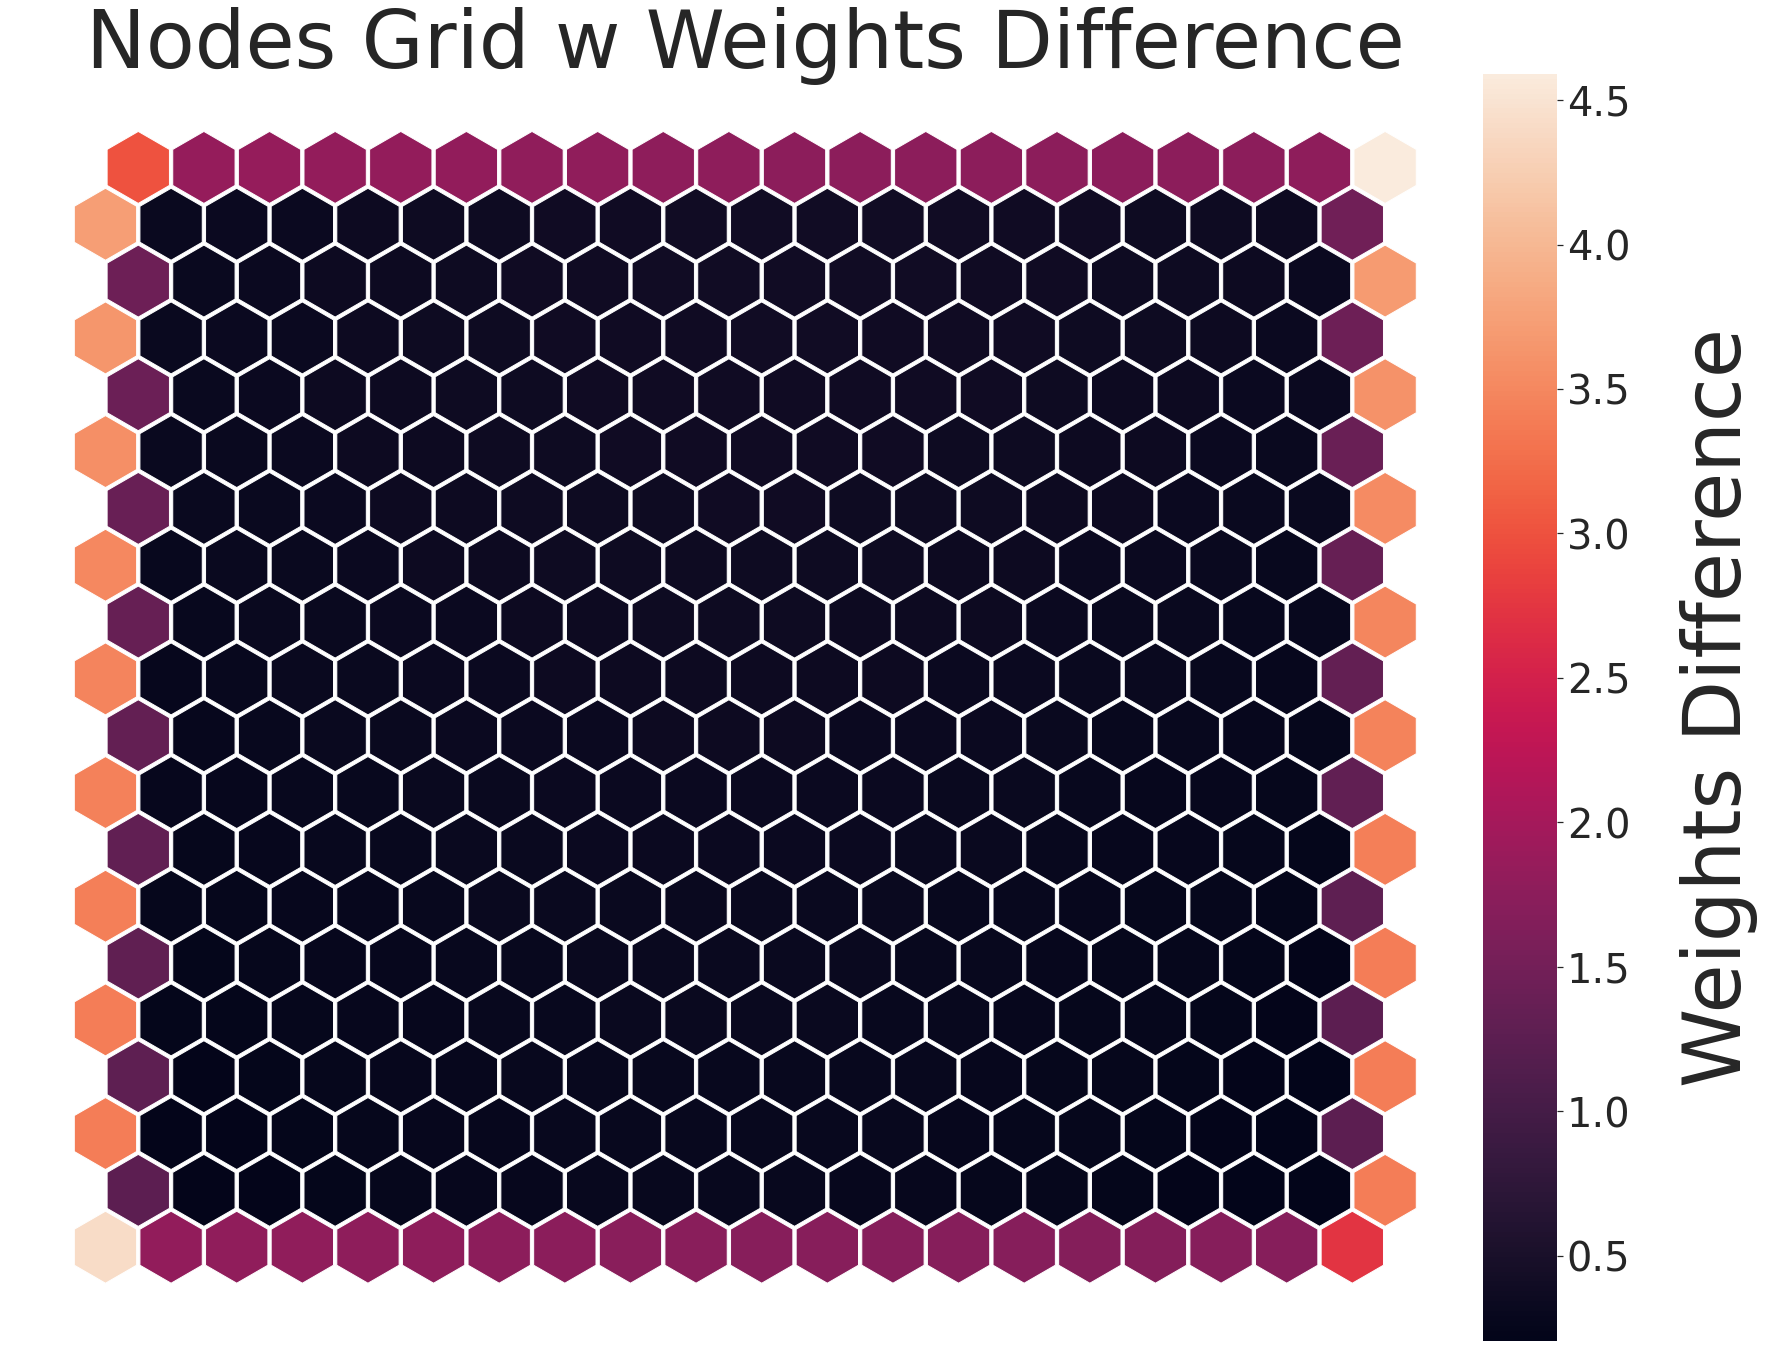

<Figure size 640x480 with 0 Axes>

In [13]:
# build a network 20x20 with a weights format taken from the train_st and activate Periodic Boundary Conditions. 
som = sps.SOMNet(20, 20, train_st, PBC=True)

# train it with 0.05 learning rate for 10000 epochs
som.train(epochs=1, start_learning_rate=0.05)

# print unified distance matrix
som.diff_graph(show=True, print_out=True)

A térkép néhány csomópontjának megjelenítése

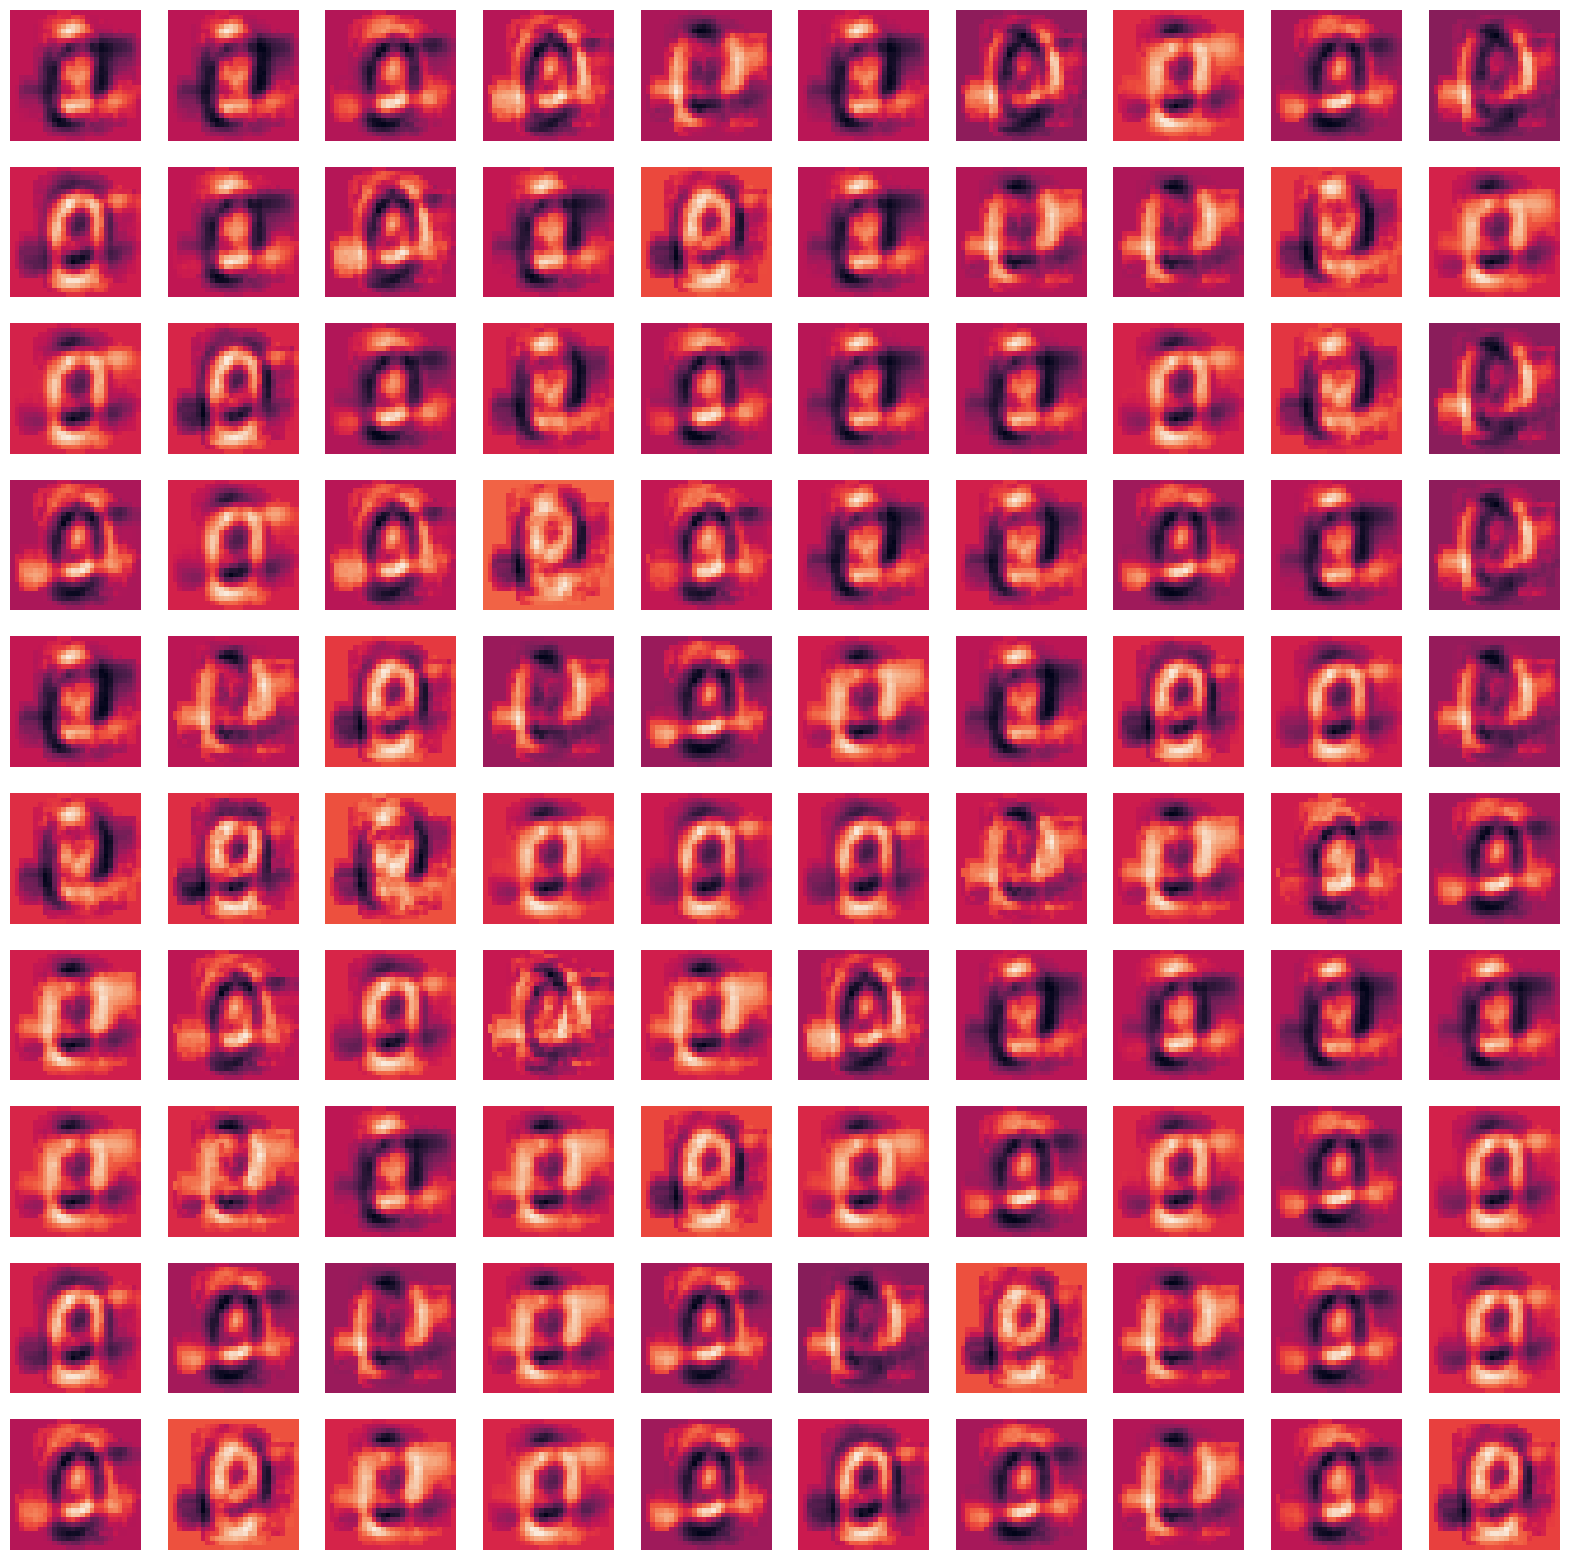

In [14]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))
axs = axs.flatten()

some_nodes_indxs = random.sample(range(len(som.node_list)), len(axs))

for i, ax in enumerate(axs):
    ax.imshow(np.asarray(som.node_list[some_nodes_indxs[i]].weights).reshape(28,28))
    ax.axis('off')

In [15]:
# print picked coordinates
', '.join([f'({i // 20}, {i % 20})' for i in some_nodes_indxs])

'(15, 6), (15, 4), (14, 12), (11, 14), (1, 17), (16, 4), (10, 16), (5, 9), (19, 16), (8, 19), (5, 2), (16, 8), (11, 15), (14, 7), (8, 1), (17, 5), (2, 16), (5, 15), (12, 0), (1, 10), (0, 6), (7, 0), (18, 11), (13, 2), (15, 11), (18, 4), (17, 4), (1, 6), (11, 5), (8, 18), (14, 16), (0, 5), (12, 14), (10, 4), (11, 11), (13, 6), (12, 5), (19, 17), (19, 4), (8, 17), (14, 4), (8, 12), (8, 2), (5, 17), (19, 19), (1, 12), (15, 3), (7, 3), (2, 3), (7, 16), (12, 1), (8, 7), (10, 7), (3, 8), (0, 0), (3, 1), (8, 11), (2, 13), (11, 10), (17, 16), (4, 12), (11, 12), (5, 5), (9, 11), (3, 12), (11, 17), (16, 2), (17, 8), (17, 0), (18, 5), (4, 10), (8, 10), (17, 6), (4, 11), (8, 3), (3, 9), (19, 14), (5, 7), (19, 15), (3, 4), (5, 3), (16, 16), (4, 18), (2, 12), (16, 18), (6, 19), (9, 6), (2, 15), (15, 13), (6, 6), (12, 13), (9, 2), (5, 11), (0, 8), (17, 18), (6, 0), (18, 15), (4, 15), (12, 11), (8, 5)'

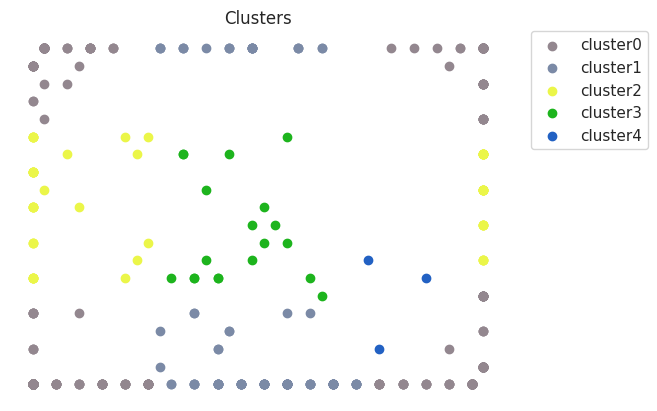

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  8,
  10,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  24,
  25,
  28,
  31,
  33,
  34,
  35,
  38,
  39,
  40,
  41,
  42,
  45,
  46,
  47,
  48,
  50,
  52,
  54,
  55,
  56,
  57,
  58,
  59,
  61,
  62,
  63,
  64,
  66,
  67,
  68,
  69,
  71,
  72,
  74,
  76,
  78,
  79,
  80,
  81,
  83,
  85,
  86,
  87,
  88,
  89,
  90,
  92,
  93,
  94,
  95,
  96,
  99,
  104,
  106,
  107,
  108,
  109,
  110,
  112,
  113,
  114,
  115,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  155,
  156,
  157,
  158,
  159,
  163,
  164,
  166,
  167,
  168,
  169,
  170,
  172,
  173,
  174,
  176,
  178,
  179,
  180,
  181,
  182,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  194,
  195,
  199,
  200,
  202,
  203,
  204,
  207,
  208,
  209,
  214,
  

<Figure size 640x480 with 0 Axes>

In [16]:
#Cluster the datapoints according to the Quality Threshold algorithm.
som.cluster(train_st, clus_type='qthresh', show=True)

# Megoldandó feladatok:
Javítsd a model teljesítményét, szabályozd a paramétereket, valyon melyik lesz az ideállís paraméter?

Most ilyen: 
sps.SOMNet(20, 20, train_st, PBC=True)

som.train(epochs=1, start_learning_rate=0.05)

Paraméter készlet: https://simpsom.readthedocs.io/en/latest/api.html

Érdekes anyag tanulmányozás céljából: https://simpsom.readthedocs.io/en/latest/tutorial_MNIST.html